In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import random

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LayerNormalization, Dropout
from tensorflow.keras.layers import Attention
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization,Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
def load_and_split_data(filepath, sequence_length, predict_length, scaler_X=None, scaler_y=None):
    data = pd.read_csv(filepath)
    # 特征和标签的定义
    features = ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']
    label = 'cnt'
    data['dteday'] = pd.to_datetime(data['dteday'])
    data['dteday'] = data['dteday'].dt.day 
    X = data[features]
    y = data[label]
    
    if scaler_X is None:
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler_X.fit_transform(X)
    else:
        X_scaled = scaler_X.transform(X)
    
    if scaler_y is None:
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    else:
        y_scaled = scaler_y.transform(y.values.reshape(-1, 1))
    
    X_processed, y_processed = [], []
    for i in range(len(X_scaled) - sequence_length - predict_length + 1):
        X_processed.append(X_scaled[i:i + sequence_length])
        y_processed.append(y_scaled[i + sequence_length:i + sequence_length + predict_length])
    
    X_processed, y_processed = np.array(X_processed), np.array(y_processed)
    
    return X_processed, y_processed, scaler_X, scaler_y

In [4]:
train_file_path = 'train_data.csv'
test_file_path = 'test_data.csv'
sequence_length=96
short_predict_length=96
long_predict_length=240

In [5]:
# 短期预测
X_train_short, y_train_short, scaler_X_short, scaler_y_short= load_and_split_data(train_file_path,sequence_length,short_predict_length)
X_test_short, y_test_short,_,_ = load_and_split_data(test_file_path,sequence_length,short_predict_length,scaler_X_short,scaler_y_short)
# 长期预测
X_train_long, y_train_long, scaler_X_long, scaler_y_long = load_and_split_data(train_file_path,sequence_length,long_predict_length)
X_test_long, y_test_long,_,_ = load_and_split_data(test_file_path,sequence_length,long_predict_length,scaler_X_long,scaler_y_long)
print(X_train_short.shape,y_train_short.shape)
print(X_test_short.shape,y_test_short.shape)
print(X_train_long.shape,y_train_long.shape)
print(X_test_long.shape,y_test_long.shape)
#print(X_train[0,0],y_train[0,0])

(15025, 96, 16) (15025, 96, 1)
(1969, 96, 16) (1969, 96, 1)
(14881, 96, 16) (14881, 240, 1)
(1825, 96, 16) (1825, 240, 1)


In [6]:
# 超参数定义
embed_dim = 64
num_heads = 4
ff_dim = 128
num_layers = 2
num_epochs = 10
batch_size = 32
num_trials = 10

In [7]:
import tensorflow as tf

def positional_encoding(seq_len, embed_dim):
    position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]  # (seq_len, 1)
    div_term = tf.exp(tf.range(0, embed_dim, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / embed_dim))  # (embed_dim // 2)
    # 计算正弦和余弦的位置编码
    pe = tf.zeros((seq_len, embed_dim), dtype=tf.float32)
    # 对偶数位置应用正弦函数
    sin_values = tf.sin(position * div_term)  # (seq_len, embed_dim//2)
    # 对奇数位置应用余弦函数
    cos_values = tf.cos(position * div_term)  # (seq_len, embed_dim//2)
    # 拼接正弦和余弦
    pe = tf.concat([sin_values, cos_values], axis=-1)  # 拼接成 (seq_len, embed_dim)
    return pe


In [8]:
def create_lstm_transformer_with_auto_feature_learning(input_shape, sequence_length, predict_length, embed_dim=64, num_heads=4, ff_dim=128, num_layers=2):
    inputs = layers.Input(shape=input_shape)
    
    # 自动学习数值特征：使用 Dense 层进行特征学习
    x = layers.Dense(64, activation='relu')(inputs)  # 自动提取数值特征的高维表示

    # LSTM 层：捕捉局部时间依赖
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)

    # Transformer 层：捕捉全局依赖
    for _ in range(num_layers):
        # 添加位置编码
        pos_encoding = positional_encoding(sequence_length, 256)  # 维度调整为 256，确保与 x 相同
        pos_encoding = tf.expand_dims(pos_encoding, axis=0)  # 将位置编码维度扩展为 (1, seq_len, embed_dim)
        x = x + pos_encoding  # 将位置编码加到输入的 x 上
        

        # 自注意力机制
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        attn_output = layers.Dropout(0.2)(attn_output)

        # 调整 attn_output 的维度以与 x 相匹配
        attn_output = layers.Dense(256)(attn_output)  # 确保维度为 256
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)  # 残差连接

        # 前馈神经网络
        ffn_output = layers.Dense(ff_dim, activation='relu')(x)
        ffn_output = layers.Dense(256)(ffn_output)  # 确保维度为 256
        ffn_output = layers.Dropout(0.2)(ffn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)  # 残差连接

    # 池化层：通过池化层进行降维
    x = layers.GlobalAveragePooling1D()(x)

    # 输出层
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(predict_length)(x)  # 输出未来的预测值

    model = models.Model(inputs=inputs, outputs=output)
    
    # 编译模型
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    model.summary()
    
    return model

In [9]:
def train_and_evaluate(model, train_data, test_data, num_epochs, batch_size):
    X_train, y_train = train_data
    X_test, y_test = test_data
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=[tf.keras.metrics.MeanAbsoluteError()])
    # 训练模型
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=num_epochs, batch_size=batch_size,callbacks=[reduce_lr, early_stopping], verbose=1)
    mse, mae = model.evaluate(X_test, y_test, verbose=1)
    return mse, mae

# 短期预测

In [10]:
him_model_short  = create_lstm_transformer_with_auto_feature_learning((sequence_length, 16), sequence_length, short_predict_length)
him_model_mse_results_short = []
him_model_mae_results_short = []
for i in range(num_trials):
    print(f"Trial {i}")
    mse, mae = train_and_evaluate(him_model_short , (X_train_short, y_train_short), (X_test_short, y_test_short), num_epochs, batch_size)
    him_model_mse_results_short.append(mse)
    him_model_mae_results_short.append(mae)




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 16)]             0         []                            
                                                                                                  
 dense (Dense)               (None, 96, 64)               1088      ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 96, 256)              197632    ['dense[0][0]']               
 al)                                                                                              
                                                                                                  
 dropout (Dropout)           (None, 96, 256)              0         ['bidirectional[0][0]']  

                                                                                                  
 dense_8 (Dense)             (None, 96)                   6240      ['dense_7[0][0]']             
                                                                                                  
Total params: 1014240 (3.87 MB)
Trainable params: 1013728 (3.87 MB)
Non-trainable params: 512 (2.00 KB)
__________________________________________________________________________________________________
Trial 0
Epoch 1/10

376/376 [==============================] - 94s 227ms/step - loss: 0.0257 - mean_absolute_error: 0.1181 - val_loss: 0.0459 - val_mean_absolute_error: 0.1609 - lr: 0.0010
Epoch 2/10
376/376 [==============================] - 86s 228ms/step - loss: 0.0138 - mean_absolute_error: 0.0849 - val_loss: 0.0294 - val_mean_absolute_error: 0.1260 - lr: 0.0010
Epoch 3/10
376/376 [==============================] - 87s 231ms/step - loss: 0.0114 - mean_absolute_error: 0.0758 - val_loss: 0.026

376/376 [==============================] - 85s 225ms/step - loss: 0.0096 - mean_absolute_error: 0.0683 - val_loss: 0.0271 - val_mean_absolute_error: 0.1154 - lr: 5.0000e-04
Epoch 8/10
376/376 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0683
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 3.
376/376 [==============================] - 86s 227ms/step - loss: 0.0096 - mean_absolute_error: 0.0683 - val_loss: 0.0268 - val_mean_absolute_error: 0.1152 - lr: 5.0000e-04
Epoch 8: early stopping
62/62 [==============================] - 4s 66ms/step - loss: 0.0268 - mean_absolute_error: 0.1148
Trial 4
Epoch 1/10
376/376 [==============================] - 93s 226ms/step - loss: 0.0097 - mean_absolute_error: 0.0689 - val_loss: 0.0280 - val_mean_absolute_error: 0.1165 - lr: 0.0010
Epoch 2/10
376/376 [==============================] - 85s 225ms/step - loss: 0.0097 - mean_absolute_e

376/376 [==============================] - 86s 229ms/step - loss: 0.0096 - mean_absolute_error: 0.0682 - val_loss: 0.0269 - val_mean_absolute_error: 0.1145 - lr: 5.0000e-04
Epoch 7: early stopping
62/62 [==============================] - 4s 64ms/step - loss: 0.0274 - mean_absolute_error: 0.1155
Trial 8
Epoch 1/10
376/376 [==============================] - 94s 225ms/step - loss: 0.0096 - mean_absolute_error: 0.0685 - val_loss: 0.0271 - val_mean_absolute_error: 0.1147 - lr: 0.0010
Epoch 2/10
376/376 [==============================] - 86s 230ms/step - loss: 0.0096 - mean_absolute_error: 0.0685 - val_loss: 0.0266 - val_mean_absolute_error: 0.1145 - lr: 0.0010
Epoch 3/10
376/376 [==============================] - 85s 226ms/step - loss: 0.0096 - mean_absolute_error: 0.0685 - val_loss: 0.0264 - val_mean_absolute_error: 0.1153 - lr: 0.0010
Epoch 4/10
376/376 [==============================] - 84s 223ms/step - loss: 0.0097 - mean_absolute_error: 0.0685 - val_loss: 0.0270 - val_mean_absolute_err

In [11]:
# 输出平均值和标准差
print(f"Average MSE: {np.mean(him_model_mse_results_short):.4f} ±  {np.std(him_model_mse_results_short):.4f}")
print(f"Average MAE: {np.mean(him_model_mae_results_short):.4f} ± {np.std(him_model_mae_results_short):.4f}")

Average MSE: 0.0269 ±  0.0005
Average MAE: 0.1151 ± 0.0009


In [12]:
# 模型预测
y_pred_short_him_model = him_model_short.predict(X_test_short)

# 反归一化预测值与真实值
y_pred_short_him_model = scaler_y_short.inverse_transform(y_pred_short_him_model.reshape(-1, 1))
y_test_short_him_model = scaler_y_short.inverse_transform(y_test_short.reshape(-1, 1))

62/62 [==============================] - 6s 75ms/step


In [13]:
print(y_test_short_him_model, y_test_short_him_model)

[[785.]
 [384.]
 [260.]
 ...
 [ 90.]
 [ 61.]
 [ 49.]] [[785.]
 [384.]
 [260.]
 ...
 [ 90.]
 [ 61.]
 [ 49.]]


In [14]:
# 可视化预测结果
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true[:300], label='Ground Truth',color='blue')
    plt.plot(y_pred[:300], label='Predictions',color='red')
    plt.xlabel('instant')
    plt.ylabel('cnt')
    plt.title(title)
    plt.legend()
    plt.show()

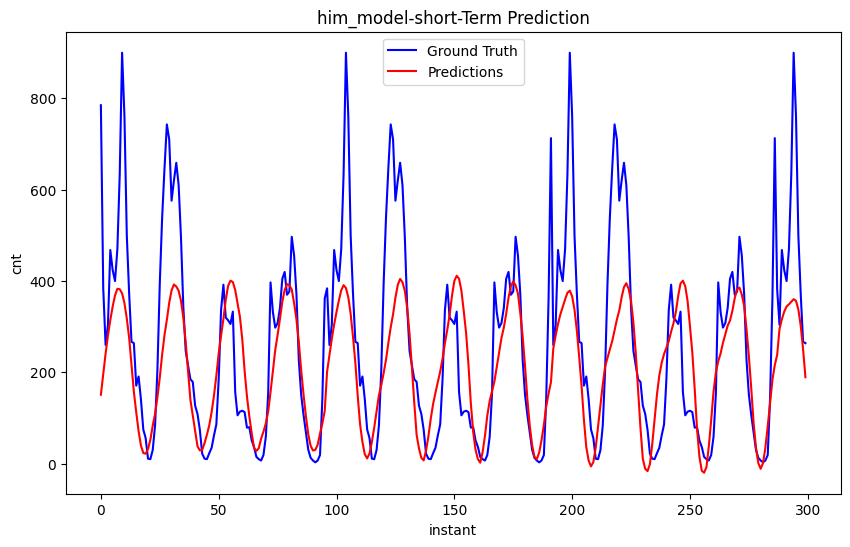

In [15]:
plot_predictions(y_test_short_him_model  .flatten(), y_pred_short_him_model  .flatten(), 'him_model-short-Term Prediction')

In [16]:
print(y_test_short_him_model.shape)
print(y_pred_short_him_model.shape)

(189024, 1)
(189024, 1)


# 长期预测

In [17]:
him_model_long  = create_lstm_transformer_with_auto_feature_learning((sequence_length, 16), sequence_length, long_predict_length)
him_model_mse_results_long = []
him_model_mae_results_long = []
for i in range(num_trials):
    print(f"Trial {i}")
    mse, mae = train_and_evaluate(him_model_long , (X_train_long, y_train_long), (X_test_long, y_test_long), num_epochs, batch_size)
    him_model_mse_results_long.append(mse)
    him_model_mae_results_long.append(mae)
# 输出平均值和标准差
print(f"Average MSE: {np.mean(him_model_mse_results_long):.4f} ±  {np.std(him_model_mse_results_long):.4f}")
print(f"Average MAE: {np.mean(him_model_mae_results_long):.4f} ± {np.std(him_model_mae_results_long):.4f}")# 模型预测
y_pred_long_him_model = him_model_long.predict(X_test_long)

# 反归一化预测值与真实值
y_pred_long_him_model = scaler_y_long.inverse_transform(y_pred_long_him_model.reshape(-1, 1))
y_test_long_him_model = scaler_y_long.inverse_transform(y_test_long.reshape(-1, 1))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 16)]             0         []                            
                                                                                                  
 dense_9 (Dense)             (None, 96, 64)               1088      ['input_2[0][0]']             
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 96, 256)              197632    ['dense_9[0][0]']             
 onal)                                                                                            
                                                                                                  
 dropout_5 (Dropout)         (None, 96, 256)              0         ['bidirectional_1[0][0]'

                                                                                                  
 dense_16 (Dense)            (None, 64)                   16448     ['global_average_pooling1d_1[0
                                                                    ][0]']                        
                                                                                                  
 dense_17 (Dense)            (None, 240)                  15600     ['dense_16[0][0]']            
                                                                                                  
Total params: 1023600 (3.90 MB)
Trainable params: 1023088 (3.90 MB)
Non-trainable params: 512 (2.00 KB)
__________________________________________________________________________________________________
Trial 0
Epoch 1/10
372/372 [==============================] - 101s 252ms/step - loss: 0.0224 - mean_absolute_error: 0.1106 - val_loss: 0.0295 - val_mean_absolute_error: 0.1252 - lr: 0.0010
Epoch 2/10
372

372/372 [==============================] - 87s 233ms/step - loss: 0.0092 - mean_absolute_error: 0.0681 - val_loss: 0.0227 - val_mean_absolute_error: 0.1101 - lr: 0.0010
Epoch 4/10
372/372 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0681
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
372/372 [==============================] - 86s 232ms/step - loss: 0.0092 - mean_absolute_error: 0.0681 - val_loss: 0.0228 - val_mean_absolute_error: 0.1104 - lr: 0.0010
Epoch 5/10
372/372 [==============================] - 86s 232ms/step - loss: 0.0091 - mean_absolute_error: 0.0674 - val_loss: 0.0223 - val_mean_absolute_error: 0.1094 - lr: 5.0000e-04
Epoch 6/10
372/372 [==============================] - 86s 232ms/step - loss: 0.0090 - mean_absolute_error: 0.0674 - val_loss: 0.0226 - val_mean_absolute_error: 0.1102 - lr: 5.0000e-04
Epoch 6: early stopping
58/58 [==============================] - 4s 70ms/step - loss: 0.0269 - mean_absolute_er

Epoch 5/10
372/372 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0677
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
372/372 [==============================] - 86s 231ms/step - loss: 0.0091 - mean_absolute_error: 0.0677 - val_loss: 0.0220 - val_mean_absolute_error: 0.1085 - lr: 0.0010
Epoch 6/10
372/372 [==============================] - 86s 231ms/step - loss: 0.0090 - mean_absolute_error: 0.0673 - val_loss: 0.0221 - val_mean_absolute_error: 0.1087 - lr: 5.0000e-04
Epoch 7/10
372/372 [==============================] - 87s 234ms/step - loss: 0.0090 - mean_absolute_error: 0.0673 - val_loss: 0.0221 - val_mean_absolute_error: 0.1088 - lr: 5.0000e-04
Epoch 7: early stopping
58/58 [==============================] - 4s 70ms/step - loss: 0.0267 - mean_absolute_error: 0.1134
Average MSE: 0.0269 ±  0.0002
Average MAE: 0.1136 ± 0.0008
58/58 [==============================] - 5s 66ms/step


In [18]:
print(y_test_long_him_model.shape, y_test_long_him_model.shape)

(438000, 1) (438000, 1)


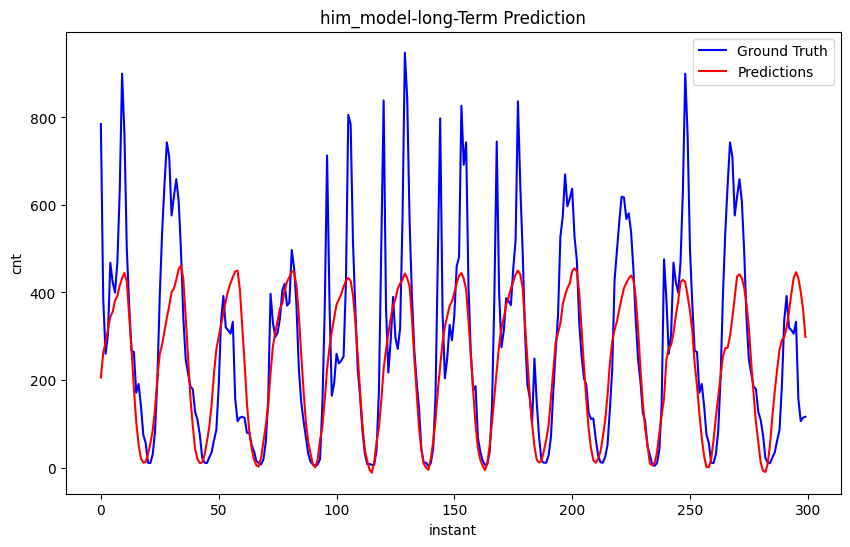

In [19]:
plot_predictions(y_test_long_him_model  .flatten(), y_pred_long_him_model  .flatten(), 'him_model-long-Term Prediction')